#### I. Imports & Load

In [34]:
# Standard library
import tempfile
from copy import deepcopy
from typing import Sequence, Optional, Callable
from unidecode import unidecode
import shutil

# Third-party: core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from typing import Any

# scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
    root_mean_squared_error as _rmse,
    mean_squared_error as _mse,
)

from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_validate,
    RandomizedSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer


# Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


# MLflow
import mlflow
from mlflow.tracking import MlflowClient

In [2]:
# MLflow configuration
TRACKING_URI = "https://flodussart-getaround-mlflow.hf.space"
EXPERIMENT_NAME = "getaround-exp-seven"

# Apply configuration
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

# Display current experiment info
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print(
    f"Connected to MLflow \nTracking URI: {TRACKING_URI}\nExperiment: {experiment.name} (ID: {experiment.experiment_id})"
)

Connected to MLflow 
Tracking URI: https://flodussart-getaround-mlflow.hf.space
Experiment: getaround-exp-seven (ID: 8)


In [3]:
CSV_URL = "https://huggingface.co/datasets/flodussart/getaround_pricing_project/resolve/main/get_around_pricing_project.csv"

#### II. Small EDA

In [4]:
df_pricing = pd.read_csv(CSV_URL)
df_pricing.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [5]:
# Work on a copy
df = df_pricing.copy()

# Drop export-artifact column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   model_key                  4843 non-null   object
 1   mileage                    4843 non-null   int64 
 2   engine_power               4843 non-null   int64 
 3   fuel                       4843 non-null   object
 4   paint_color                4843 non-null   object
 5   car_type                   4843 non-null   object
 6   private_parking_available  4843 non-null   bool  
 7   has_gps                    4843 non-null   bool  
 8   has_air_conditioning       4843 non-null   bool  
 9   automatic_car              4843 non-null   bool  
 10  has_getaround_connect      4843 non-null   bool  
 11  has_speed_regulator        4843 non-null   bool  
 12  winter_tires               4843 non-null   bool  
 13  rental_price_per_day       4843 non-null   int64 
dtypes: bool(

In [6]:
# Basic stats

print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include="all")
print(data_desc)

print("Percentage of missing values: ")
display(100 * df.isnull().sum() / df.shape[0])

Number of rows : 4843

Display of dataset: 


,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183



Basics statistics: 
       model_key       mileage  engine_power    fuel paint_color car_type  \
count       4843  4.843000e+03    4843.00000    4843        4843     4843   
unique        28           NaN           NaN       4          10        8   
top      Citroën           NaN           NaN  diesel       black   estate   
freq         969           NaN           NaN    4641        1633     1606   
mean         NaN  1.409628e+05     128.98823     NaN         NaN      NaN   
std          NaN  6.019674e+04      38.99336     NaN         NaN      NaN   
min          NaN -6.400000e+01       0.00000     NaN         NaN      NaN   
25%          NaN  1.029135e+05     100.00000     NaN         NaN      NaN   
50%          NaN  1.410800e+05     120.00000     NaN         NaN      NaN   
75%          NaN  1.751955e+05     135.00000     NaN         NaN      NaN   
max          NaN  1.000376e+06     423.00000     NaN         NaN      NaN   

       private_parking_available has_gps has_air_condi

model_key                    0.0
mileage                      0.0
engine_power                 0.0
fuel                         0.0
paint_color                  0.0
car_type                     0.0
private_parking_available    0.0
has_gps                      0.0
has_air_conditioning         0.0
automatic_car                0.0
has_getaround_connect        0.0
has_speed_regulator          0.0
winter_tires                 0.0
rental_price_per_day         0.0
dtype: float64

#### Variables numériques

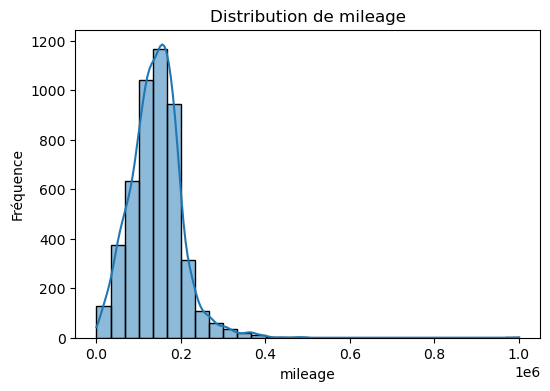

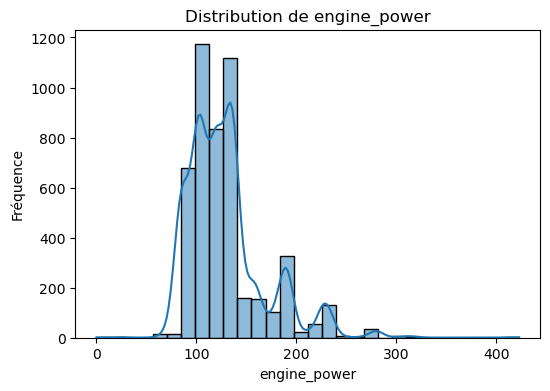

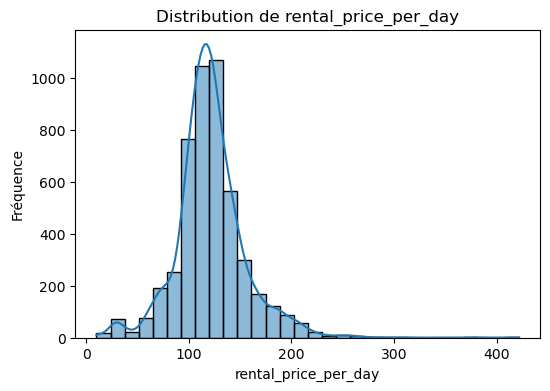

In [ ]:
# Visualize distributions of numeric features
numeric_cols = ["mileage", "engine_power", "rental_price_per_day"]

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()

mileage

In [ ]:
# Check for negative mileage values
neg_mask = df["mileage"] < 0
print("Number of rows with negative mileage:", neg_mask.sum())

if neg_mask.sum() > 0:
    display(df.loc[neg_mask, ["model_key", "mileage", "car_type"]])
else:
    print("No negative mileage values found.")

Number of rows with negative mileage: 1


,model_key,mileage,car_type
2938,Renault,-64,sedan


In [9]:
df[["model_key", "mileage", "car_type"]].sort_values(
    by="mileage", ascending=False
).head(10)

,model_key,mileage,car_type
3732,Citroën,1000376,subcompact
557,Renault,484615,estate
2350,Peugeot,477571,hatchback
2829,Audi,439060,sedan
3198,Citroën,405816,sedan
1573,Citroën,400654,estate
1003,Audi,398043,estate
2912,Renault,394135,sedan
1521,Audi,391309,estate
3554,Audi,388616,sedan


engine power

In [ ]:
# Check suspiciously low and high values
low_power = df[df["engine_power"] < 50]
print("Cars with unrealistically low power (<50 hp):", len(low_power))
display(low_power[["model_key", "engine_power", "fuel", "car_type"]].head(10))

high_power = df[df["engine_power"] > 250].sort_values(
    by="engine_power", ascending=False
)
print("Cars with very high power (>400 hp):", len(high_power))
display(high_power[["model_key", "engine_power", "fuel", "car_type"]].head())

Cars with unrealistically low power (<50 hp): 3


,model_key,engine_power,fuel,car_type
1796,Porsche,25,hybrid_petrol,hatchback
1925,Porsche,25,hybrid_petrol,hatchback
3765,Nissan,0,diesel,suv


Cars with very high power (>400 hp): 46


,model_key,engine_power,fuel,car_type
4146,Suzuki,423,petrol,suv
3601,Mini,412,petrol,sedan
1,Citroën,317,petrol,convertible
72,Citroën,317,petrol,coupe
3092,Peugeot,317,petrol,sedan


In [ ]:
# Final outlier cleaning (US 2017 context)

# Remove unrealistic mileage and power values
df = df[
    (df["mileage"] >= 0)
    & (df["mileage"] <= 400000)  # upper bound: realistic max mileage for US cars
    & (df["engine_power"] >= 50)  # no car under 50 hp in US
    & (df["engine_power"] <= 400)  # reasonable upper bound (SUVs, pickups)
].copy()

# Optional: check ±3 std consistency
mileage_mean, mileage_std = df["mileage"].mean(), df["mileage"].std()
power_mean, power_std = df["engine_power"].mean(), df["engine_power"].std()

print(
    "Mileage bounds (±3 std):",
    mileage_mean - 3 * mileage_std,
    "to",
    mileage_mean + 3 * mileage_std,
)
print(
    "Engine power bounds (±3 std):",
    power_mean - 3 * power_std,
    "to",
    power_mean + 3 * power_std,
)

print("\nSummary statistics after cleaning:")
print(df[["mileage", "engine_power"]].describe())

Mileage bounds (±3 std): -33770.34978023122 to 314844.69670633343
Engine power bounds (±3 std): 13.592156857624758 to 244.31096878923924

Summary statistics after cleaning:
             mileage  engine_power
count    4831.000000   4831.000000
mean   140537.173463    128.951563
std     58102.507748     38.453135
min       476.000000     66.000000
25%    102913.500000    100.000000
50%    140991.000000    120.000000
75%    175167.500000    135.000000
max    398043.000000    317.000000


#### Variables catégorielles 

In [ ]:
def bar_pct(df, var, title_suffix="(%)"):
    """
    Create a percentage bar chart for a categorical or boolean variable.
    """

    # Compute category percentages
    counts = (
        df[var]
        .astype(str) 
        .value_counts(normalize=True) 
        .mul(100)  
        .rename_axis(var) 
        .reset_index(name="percentage")  
        .sort_values("percentage", ascending=False) 
    )

    fig = px.bar(
        counts,
        x=var,
        y="percentage",
        text="percentage",  
        title=f"Répartition de {var} {title_suffix}",
        color=var,  
        color_discrete_sequence=px.colors.qualitative.Pastel,  
    )

    fig.update_traces(
        texttemplate="%{text:.1f}%",  
        textposition="outside", 
        textfont_size=14,  
    )

    # Layout 
    fig.update_layout(
        title={"x": 0.5, "xanchor": "center", "font": {"size": 20}},  
        yaxis_title="Pourcentage (%)",
        xaxis_title=var,
        showlegend=False,
        height=500, 
        margin=dict(t=100, b=80, l=50, r=50),  
        template="plotly_white",
    )

    fig.update_yaxes(range=[0, counts["percentage"].max() * 1.15])

    fig.show()


# Categorical variables
for var in ["fuel", "paint_color", "car_type", "model_key"]:
    bar_pct(df, var)

# Boolean variables
for var in [
    "private_parking_available",
    "has_gps",
    "has_air_conditioning",
    "automatic_car",
    "has_getaround_connect",
    "has_speed_regulator",
    "winter_tires",
]:
    bar_pct(df, var)

In [ ]:
# Normalize categorical values to ensure consistent keys (case, accents, spaces)
def normalize(s: str):
    return unidecode(str(s)).strip().lower()

df["model_key"] = df["model_key"].apply(normalize)
df["fuel"] = df["fuel"].apply(normalize)
df["paint_color"] = df["paint_color"].apply(normalize)
df["car_type"] = df["car_type"].apply(normalize)

In [ ]:
# Group rare categories to stabilize the model and reduce one-hot columns

# Fuel: merge very rare fuels into 'other'
df["fuel_grouped"] = df["fuel"].replace({"hybrid_petrol": "other", "electro": "other"})

# Paint color: merge very rare colors into 'other'
rare_colors = ["red", "beige", "green", "orange"]
df["paint_color_grouped"] = df["paint_color"].replace({c: "other" for c in rare_colors})

# Car type: merge rare body types into 'other'
rare_types = ["subcompact", "coupe", "convertible", "van"]
df["car_type_grouped"] = df["car_type"].replace({t: "other" for t in rare_types})

# Model key (brand): merge brands <1% into 'other'
df["model_key_grouped"] = df["model_key"]  
freq = df["model_key"].value_counts(normalize=True)  
rare_models = freq[freq < 0.01].index 
df.loc[df["model_key"].isin(rare_models), "model_key_grouped"] = "other"

for var in [
    "fuel_grouped",
    "paint_color_grouped",
    "car_type_grouped",
    "model_key_grouped",
]:
    bar_pct(df, var)

In [15]:
df.head()

,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day,fuel_grouped,paint_color_grouped,car_type_grouped,model_key_grouped
0,citroen,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106,diesel,black,other,citroen
1,citroen,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264,petrol,grey,other,citroen
2,citroen,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101,diesel,white,other,citroen
3,citroen,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158,diesel,other,other,citroen
4,citroen,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183,diesel,silver,other,citroen


### III. Preprocessing

In [ ]:
# Train/Test Split

# Target variable 
TARGET = "rental_price_per_day"

# Data split configuration
TEST_SIZE = 0.20 
RANDOM_STATE = 42  

y = df[TARGET]
X = df.drop(columns=[TARGET])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(X_train.shape, X_test.shape)

(3864, 17) (967, 17)


In [17]:
# Feature Groups

# Numerical continuous features
NUM = ["mileage", "engine_power"]

# Candidate categorical features
# (we will test different combinations later)
CAT_MASTER = [
    "model_key",
    "fuel",
    "paint_color",
    "car_type",
    "model_key_grouped",
    "fuel_grouped",
    "paint_color_grouped",
    "car_type_grouped",
]

# Boolean binary encoded features
BOOL = [
    "private_parking_available",
    "has_gps",
    "has_air_conditioning",
    "automatic_car",
    "has_getaround_connect",
    "has_speed_regulator",
    "winter_tires",
]

In [18]:
def build_preprocessor_linear(cats):
    num = Pipeline(
        [
            ("scaler", StandardScaler()),
        ]
    )
    cat = Pipeline(
        [
            (
                "ohe",
                OneHotEncoder(
                    drop="first",
                    handle_unknown="ignore",
                    sparse_output=False,
                    dtype=np.float32,
                ),
            ),
        ]
    )
    boo = Pipeline(
        [
            (
                "ohe",
                OneHotEncoder(
                    drop="if_binary",
                    handle_unknown="ignore",
                    sparse_output=False,
                    dtype=np.float32,
                ),
            ),
        ]
    )
    return ColumnTransformer(
        transformers=[
            ("num", num, list(NUM)),
            ("cat", cat, list(cats)),
            ("bool", boo, list(BOOL)),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
        sparse_threshold=0.0,  # force dense
    )


def build_preprocessor_trees(cats):
    cat = Pipeline(
        [
            (
                "ohe",
                OneHotEncoder(
                    drop=None,
                    handle_unknown="ignore",
                    sparse_output=True,
                    dtype=np.float32,
                ),
            ),
        ]
    )
    boo = Pipeline(
        [
            ("to_int", FunctionTransformer(lambda X: X.astype(np.int8))),
        ]
    )
    return ColumnTransformer(
        transformers=[
            ("num", "passthrough", list(NUM)),
            ("cat", cat, list(cats)),
            ("bool", boo, list(BOOL)),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

In [ ]:
# Candidate categorical feature sets to evaluate
# Each list represents a different how-we-encode-categories strategy.
# We will run experiments by testing each set independently.

cat_sets = [
    ["model_key_grouped", "fuel_grouped", "paint_color_grouped", "car_type_grouped"],
    ["model_key", "fuel", "paint_color", "car_type"],
    ["model_key", "fuel_grouped", "paint_color_grouped", "car_type_grouped"],
    ["model_key", "fuel_grouped", "paint_color", "car_type_grouped"],
    ["model_key", "fuel_grouped", "paint_color", "car_type"],
    ["model_key", "fuel", "paint_color", "car_type_grouped"],
    ["model_key_grouped", "fuel_grouped", "car_type_grouped"],
    ["model_key_grouped", "fuel_grouped", "paint_color", "car_type_grouped"],
]

# Remove duplicates while preserving order
cat_sets = [list(t) for t in dict.fromkeys(tuple(s) for s in cat_sets)]

print(f"{len(cat_sets)} distinct categorical sets to test")
for s in cat_sets:
    print(" -", s)

8 distinct categorical sets to test
 - ['model_key_grouped', 'fuel_grouped', 'paint_color_grouped', 'car_type_grouped']
 - ['model_key', 'fuel', 'paint_color', 'car_type']
 - ['model_key', 'fuel_grouped', 'paint_color_grouped', 'car_type_grouped']
 - ['model_key', 'fuel_grouped', 'paint_color', 'car_type_grouped']
 - ['model_key', 'fuel_grouped', 'paint_color', 'car_type']
 - ['model_key', 'fuel', 'paint_color', 'car_type_grouped']
 - ['model_key_grouped', 'fuel_grouped', 'car_type_grouped']
 - ['model_key_grouped', 'fuel_grouped', 'paint_color', 'car_type_grouped']


In [ ]:
# Metrics utility: version-safe RMSE to ensure reproducible evaluation across sklearn versions
try:
    def rmse(y_true, y_pred) -> float:
        """Compute RMSE (Root Mean Squared Error) in a version-safe way."""
        return float(_rmse(y_true, y_pred))

except Exception:
    # Fallback for older sklearn (no root_mean_squared_error / no squared kw)
    def rmse(y_true, y_pred) -> float:
        """Compute RMSE (Root Mean Squared Error) in a version-safe way."""
        return float(np.sqrt(_mse(y_true, y_pred)))

#### IV. Training orchestration & experiment tracking

In [ ]:
# One-run training + evaluation + MLflow logging helper
def train_and_log_one_run(
    model_name: str,
    model: Any,  
    preprocessor_builder: Callable[[Sequence[str]], Any],
    cat_cols: Sequence[str],  
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    X_full: pd.DataFrame,  # for cross-validation
    y_full: pd.Series,  # for cross-validation
    do_cv: bool = True,
    cv_splits: int = 5,
    random_state: int = 42,
    tags: Optional[dict[str, str]] = None,
    run_name: Optional[str] = None,
) -> dict[str, Any]:
    """
    Build a (preprocessor -> regressor) Pipeline, fit/evaluate it, and log everything to MLflow.
    """
    # Build pipeline (preprocessor + estimator)
    preproc = preprocessor_builder(cat_cols)
    pipe = Pipeline(steps=[("preprocessor", preproc), ("regressor", model)])

    # Start MLflow run
    with mlflow.start_run(run_name=run_name or model_name) as run:
        all_tags: dict[str, str] = {"model_name": model_name}
        if tags:
            all_tags.update(tags)
        mlflow.set_tags(all_tags)

        # Params describing the feature set
        mlflow.log_param("cats", ",".join(cat_cols))
        mlflow.log_param("n_num", len(NUM))
        mlflow.log_param("n_bool", len(BOOL))
        mlflow.log_param("n_cat", len(cat_cols))

        # Log estimator hyperparameters 
        try:
            for p, v in model.get_params().items():
                # keep values JSON-serializable for MLflow UI
                mlflow.log_param(f"model__{p}", v)
        except Exception:
            # some non-sklearn models may not expose get_params()
            pass

        # Fit + predict on hold-out
        pipe.fit(X_train, y_train)
        y_pred_tr = pipe.predict(X_train)
        y_pred_te = pipe.predict(X_test)

        holdout = {
            "train_mae": float(mean_absolute_error(y_train, y_pred_tr)),
            "train_rmse": float(rmse(y_train, y_pred_tr)),
            "train_r2": float(r2_score(y_train, y_pred_tr)),
            "test_mae": float(mean_absolute_error(y_test, y_pred_te)),
            "test_rmse": float(rmse(y_test, y_pred_te)),
            "test_r2": float(r2_score(y_test, y_pred_te)),
        }
        mlflow.log_metrics(holdout)

        # Cross-validation 
        cv_summary: Optional[dict[str, float]] = None
        if do_cv:
            cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
            cv_res = cross_validate(
                estimator=pipe,
                X=X_full,
                y=y_full,
                cv=cv,
                scoring={
                    "r2": "r2",
                    "mse": "neg_mean_squared_error",
                    "mae": "neg_mean_absolute_error",
                },
                n_jobs=-1,
                return_train_score=False,
            )

            rmse_folds = np.sqrt(-cv_res["test_mse"])
            mae_folds = -cv_res["test_mae"]
            r2_folds = cv_res["test_r2"]

            cv_summary = {
                "cv_rmse_mean": float(rmse_folds.mean()),
                "cv_rmse_std": float(rmse_folds.std()),
                "cv_mae_mean": float(mae_folds.mean()),
                "cv_mae_std": float(mae_folds.std()),
                "cv_r2_mean": float(r2_folds.mean()),
                "cv_r2_std": float(r2_folds.std()),
            }
            mlflow.log_metrics(cv_summary)

            mlflow.log_dict(
                {
                    "rmse_per_fold": [float(v) for v in rmse_folds],
                    "mae_per_fold": [float(v) for v in mae_folds],
                    "r2_per_fold": [float(v) for v in r2_folds],
                },
                artifact_file="cv_folds.json",
            )

        # Persist the trained pipeline and the feature manifest
        mlflow.sklearn.log_model(pipe, artifact_path="model")
        mlflow.log_dict(
            {
                "numeric": list(NUM),
                "categorical": list(cat_cols),
                "boolean": list(BOOL),
            },
            artifact_file="features_used.json",
        )

        print(
            f"{model_name} | cats={list(cat_cols)} | "
            f"RMSE={holdout['test_rmse']:.2f} | R²={holdout['test_r2']:.3f}"
        )

        return {"holdout": holdout, "cv": cv_summary, "run_id": run.info.run_id}

#### V. Régression linéaire

In [ ]:
def run_lr_experiment_all(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    X_full: pd.DataFrame,
    y_full: pd.Series,
    cat_sets: Sequence[Sequence[str]],
    do_cv: bool = True,
    cv_splits: int = 5,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Iterate over multiple categorical feature-set configurations for a *Linear Regression* baseline.
    For each set:
      - build a linear preprocessor (scaling + OHE with drop='first'),
      - train/evaluate the model on the hold-out split,
      - optionally run K-fold CV,
      - log everything to MLflow,
      - collect results into a summary DataFrame.

    The returned table is sorted by (test_rmse asc, rmse_gap asc) where:
        rmse_gap = test_rmse - train_rmse
    which slightly favors models with both low test error and low overfitting.
    """
    rows: list[dict[str, Any]] = []

    for i, cats in enumerate(cat_sets, start=1):
        # Short label for the run name (make grouped columns readable)
        short = "_".join(c.replace("_grouped", "grp") for c in cats)
        run_name = f"linreg_catset_{i}_{short}"

        # Train + log one run to MLflow
        out = train_and_log_one_run(
            model_name="LinearRegression",
            model=LinearRegression(),
            preprocessor_builder=build_preprocessor_linear,
            cat_cols=cats,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            X_full=X_full,
            y_full=y_full,
            do_cv=do_cv,
            cv_splits=cv_splits,
            random_state=random_state,
            tags={"model_family": "linear_regression", "cat_set_idx": i},
            run_name=run_name,
        )

        # Overfitting signal 
        rmse_gap = out["holdout"]["test_rmse"] - out["holdout"]["train_rmse"]

        rows.append(
            {
                "run_name": run_name,
                "cats": list(cats),
                "run_id": out["run_id"],
                "test_rmse": out["holdout"]["test_rmse"],
                "test_r2": out["holdout"]["test_r2"],
                "train_rmse": out["holdout"]["train_rmse"],
                "train_r2": out["holdout"]["train_r2"],
                "rmse_gap": rmse_gap,
                **(out["cv"] or {}),
            }
        )

    # Build results table and sort: lower test_rmse first, then lower rmse_gap
    res = (
        pd.DataFrame(rows)
        .sort_values(["test_rmse", "rmse_gap"], ascending=[True, True])
        .reset_index(drop=True)
    )

    cols_to_show = [
        "run_name",
        "test_rmse",
        "test_r2",
        "train_rmse",
        "train_r2",
        "rmse_gap",
        "cv_rmse_mean",
        "cv_r2_mean",
        "cats",
    ]
    cols_to_show = [c for c in cols_to_show if c in res.columns]
    try:
        from IPython.display import display 

        display(res[cols_to_show])
    except Exception:
        print(res[cols_to_show].head(20).to_string(index=False))

    best = res.iloc[0]
    print(
        f"\n Best (Linear) — {best['run_name']} | "
        f"RMSE={best['test_rmse']:.2f} | R²={best['test_r2']:.3f}"
    )

    return res

In [ ]:
# Run Linear Regression experiments
# Full dataset passed to CV (makes intent explicit)
df_X = X.copy()
df_y = y.copy()

# Launch the experiment over all categorical feature combinations
results_lr = run_lr_experiment_all(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_full=df_X,
    y_full=df_y,
    cat_sets=cat_sets,
    do_cv=True,
    cv_splits=5,
    random_state=RANDOM_STATE,
)

results_lr.head()

LinearRegression | cats=['model_key_grouped', 'fuel_grouped', 'paint_color_grouped', 'car_type_grouped'] | RMSE=17.23 | R²=0.730
LinearRegression | cats=['model_key', 'fuel', 'paint_color', 'car_type'] | RMSE=16.93 | R²=0.739
LinearRegression | cats=['model_key', 'fuel_grouped', 'paint_color_grouped', 'car_type_grouped'] | RMSE=17.12 | R²=0.733
LinearRegression | cats=['model_key', 'fuel_grouped', 'paint_color', 'car_type_grouped'] | RMSE=17.09 | R²=0.734
LinearRegression | cats=['model_key', 'fuel_grouped', 'paint_color', 'car_type'] | RMSE=16.93 | R²=0.739
LinearRegression | cats=['model_key', 'fuel', 'paint_color', 'car_type_grouped'] | RMSE=17.09 | R²=0.734
LinearRegression | cats=['model_key_grouped', 'fuel_grouped', 'car_type_grouped'] | RMSE=17.41 | R²=0.724
LinearRegression | cats=['model_key_grouped', 'fuel_grouped', 'paint_color', 'car_type_grouped'] | RMSE=17.20 | R²=0.730


,run_name,test_rmse,test_r2,train_rmse,train_r2,rmse_gap,cv_rmse_mean,cv_r2_mean,cats
0,linreg_catset_2_model_key_fuel_paint_color_car...,16.928083,0.738991,18.185271,0.702285,-1.257188,18.315320,0.696534,"[model_key, fuel, paint_color, car_type]"
1,linreg_catset_5_model_key_fuelgrp_paint_color_...,16.928325,0.738984,18.186673,0.702239,-1.258349,18.318330,0.696434,"[model_key, fuel_grouped, paint_color, car_type]"
2,linreg_catset_4_model_key_fuelgrp_paint_color_...,17.094346,0.733839,18.303759,0.698393,-1.209412,18.445824,0.692208,"[model_key, fuel_grouped, paint_color, car_typ..."
3,linreg_catset_6_model_key_fuel_paint_color_car...,17.094419,0.733836,18.302756,0.698426,-1.208337,18.444486,0.692254,"[model_key, fuel, paint_color, car_type_grouped]"
4,linreg_catset_3_model_key_fuelgrp_paint_colorg...,17.120030,0.733038,18.356278,0.696659,-1.236248,18.490298,0.690713,"[model_key, fuel_grouped, paint_color_grouped,..."
5,linreg_catset_8_model_keygrp_fuelgrp_paint_col...,17.204188,0.730407,18.597614,0.688631,-1.393425,18.480810,0.690942,"[model_key_grouped, fuel_grouped, paint_color,..."
6,linreg_catset_1_model_keygrp_fuelgrp_paint_col...,17.228851,0.729634,18.658505,0.686588,-1.429654,18.533667,0.689154,"[model_key_grouped, fuel_grouped, paint_color_..."
7,linreg_catset_7_model_keygrp_fuelgrp_car_typegrp,17.406515,0.724029,18.739726,0.683854,-1.333212,18.617635,0.686399,"[model_key_grouped, fuel_grouped, car_type_gro..."



 Best (Linear) — linreg_catset_2_model_key_fuel_paint_color_car_type | RMSE=16.93 | R²=0.739


,run_name,cats,run_id,test_rmse,test_r2,train_rmse,train_r2,rmse_gap,cv_rmse_mean,cv_rmse_std,cv_mae_mean,cv_mae_std,cv_r2_mean,cv_r2_std
0,linreg_catset_2_model_key_fuel_paint_color_car...,"[model_key, fuel, paint_color, car_type]",e16026b987db4c508529d23db67bf98c,16.928083,0.738991,18.185271,0.702285,-1.257188,18.315320,1.636756,12.323414,0.536431,0.696534,0.042101
1,linreg_catset_5_model_key_fuelgrp_paint_color_...,"[model_key, fuel_grouped, paint_color, car_type]",0dd1c2214bbf4fba81738fdb794b3c73,16.928325,0.738984,18.186673,0.702239,-1.258349,18.318330,1.636793,12.325756,0.533477,0.696434,0.042112
2,linreg_catset_4_model_key_fuelgrp_paint_color_...,"[model_key, fuel_grouped, paint_color, car_typ...",50cf2d14cb764a5e93052d3c24f624f4,17.094346,0.733839,18.303759,0.698393,-1.209412,18.445824,1.646050,12.347355,0.534715,0.692208,0.042621
3,linreg_catset_6_model_key_fuel_paint_color_car...,"[model_key, fuel, paint_color, car_type_grouped]",9edf9ad01d3f45f58451376fc3dc6f07,17.094419,0.733836,18.302756,0.698426,-1.208337,18.444486,1.645428,12.346741,0.535693,0.692254,0.042594
4,linreg_catset_3_model_key_fuelgrp_paint_colorg...,"[model_key, fuel_grouped, paint_color_grouped,...",b511535b76a54d40a316bf1590b8dcd3,17.120030,0.733038,18.356278,0.696659,-1.236248,18.490298,1.653951,12.410140,0.548989,0.690713,0.042982


#### VI. XGBoost

In [ ]:
# Run and log XGBoost baseline models for different categorical feature sets
# clean, stable defaults for XGBoost
XGB_DEFAULT: dict[str, Any] = {
    "objective": "reg:squarederror",
    "n_estimators": 600,
    "learning_rate": 0.05,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.5,
    "reg_lambda": 1.0,
    "min_child_weight": 2,
    "tree_method": "hist",
    "n_jobs": -1,
    "random_state": RANDOM_STATE,
    "verbosity": 0,
}


def run_xgb_baseline_all(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    X_full: pd.DataFrame,
    y_full: pd.Series,
    cat_sets: Sequence[Sequence[str]],
    do_cv: bool = True,
    cv_splits: int = 5,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Train/evaluate an XGBoost baseline on each categorical feature-set variant.

    For each `cats` list:
      - build the tree preprocessor (no scaling, OHE keep all dummies),
      - fit on train, evaluate on test,
      - optional K-fold CV on the whole dataset,
      - log params/metrics/model to MLflow through `train_and_log_one_run`,
      - collect results into a table sorted by (test_rmse asc, rmse_gap asc).
    """
    rows = []

    for i, cats in enumerate(cat_sets, start=1):
        # compact label for readability in MLflow run name
        short = "-".join(c.replace("_grouped", "grp") for c in cats)
        run_name = f"xgb_base_catset_{i}_{short}"

        out = train_and_log_one_run(
            model_name="XGBoost",
            model=XGBRegressor(**XGB_DEFAULT),
            preprocessor_builder=build_preprocessor_trees,  # <-- tree-specific preproc
            cat_cols=cats,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            X_full=X_full,
            y_full=y_full,  
            do_cv=do_cv,
            cv_splits=cv_splits,
            random_state=random_state,
            tags={"model_family": "xgboost", "cat_set_idx": i},
            run_name=run_name,
        )

        rmse_gap = out["holdout"]["test_rmse"] - out["holdout"]["train_rmse"]

        rows.append(
            {
                "run_name": run_name,
                "cats": list(cats),
                "rmse_gap": rmse_gap,
                **out["holdout"],
                **(out["cv"] or {}),
            }
        )

    df_res = (
        pd.DataFrame(rows)
        .sort_values(["test_rmse", "rmse_gap"], ascending=[True, True])
        .reset_index(drop=True)
    )
    return df_res

In [ ]:
# Run randomized hyperparameter search for XGBoost pipelines with full experiment tracking
# Search space
XGB_SEARCH_SPACE: dict[str, Sequence[Any]] = {
    "regressor__n_estimators": [400, 600, 800, 1000],
    "regressor__learning_rate": [0.03, 0.05, 0.08],
    "regressor__max_depth": [3, 4, 5, 6],
    "regressor__min_child_weight": [1, 2, 4, 6],
    "regressor__subsample": [0.6, 0.7, 0.8, 0.9],
    "regressor__colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "regressor__gamma": [0.0, 0.25, 0.5, 1.0],
    "regressor__reg_alpha": [0.0, 0.5, 1.0, 2.0, 5.0],
    "regressor__reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
}


def train_and_log_one_run_xgb_search(
    cats: Sequence[str],
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    X_full: pd.DataFrame,  # (kept for API symmetry; not used by RandomizedSearchCV itself)
    y_full: pd.Series,  # idem
    n_iter: int = 40,
    cv_splits: int = 5,
    random_state: int = 42,
    search_space: Optional[dict[str, Sequence[Any]]] = None,
    run_name: Optional[str] = None,
    tags: Optional[dict[str, str]] = None,
) -> dict[str, Any]:
    """
    Hyperparameter search for XGBoost on a given categorical feature set.
    - Builds a tree preprocessor + XGBRegressor baseline pipeline
    - RandomizedSearchCV over a clean search space (RMSE scoring)
    - Logs best params, full CV results, and hold-out metrics to MLflow
    """
    # Build pipeline: tree preprocessor + base XGB
    preproc = build_preprocessor_trees(cats)
    base_model = XGBRegressor(**XGB_DEFAULT)
    pipe = Pipeline([("preprocessor", preproc), ("regressor", base_model)])

    # Merge search spaces (allow custom overrides)
    space = dict(XGB_SEARCH_SPACE)
    if search_space:
        space.update(search_space)

    # CV & randomized search
    cv_inner = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=space,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error", 
        cv=cv_inner,
        n_jobs=-1,
        random_state=random_state,
        verbose=1,
        refit=True,  # retrain on all training data with best params
        return_train_score=False,
    )

    # MLflow logging
    with mlflow.start_run(run_name=run_name or "xgb_search") as run:
        if tags:
            mlflow.set_tags(tags)
        mlflow.log_param("cats", ",".join(cats))
        mlflow.log_param("n_cat", len(cats))
        mlflow.log_param("search_n_iter", n_iter)
        mlflow.log_param("cv_splits", cv_splits)
        mlflow.log_dict(space, "search_space.json")

        # Fit the search
        search.fit(X_train, y_train)

        # Extract best estimator & stats
        best_pipe = search.best_estimator_
        best_params = deepcopy(search.best_params_)
        best_cv_rmse = float(-search.best_score_)  # convert back to positive RMSE
        std_vec = search.cv_results_.get("std_test_score")
        best_std = (
            float(abs(std_vec[search.best_index_]))
            if std_vec is not None
            else float("nan")
        )

        # Log best params + CV summary
        mlflow.log_metric("best_cv_rmse", best_cv_rmse)
        mlflow.log_metric("best_cv_rmse_std", best_std)
        for k, v in best_params.items():
            mlflow.log_param(f"best__{k}", v)

        # Log full CV results as an artifact CSV
        cv_df = pd.DataFrame(search.cv_results_)
        with tempfile.NamedTemporaryFile("w", suffix=".csv", delete=False) as f:
            cv_df.to_csv(f.name, index=False)
            mlflow.log_artifact(f.name, artifact_path="cv_search")

        # Hold-out evaluation on the best pipeline
        y_pred_tr = best_pipe.predict(X_train)
        y_pred_te = best_pipe.predict(X_test)
        holdout = {
            "train_mae": float(mean_absolute_error(y_train, y_pred_tr)),
            "train_rmse": float(rmse(y_train, y_pred_tr)),
            "train_r2": float(r2_score(y_train, y_pred_tr)),
            "test_mae": float(mean_absolute_error(y_test, y_pred_te)),
            "test_rmse": float(rmse(y_test, y_pred_te)),
            "test_r2": float(r2_score(y_test, y_pred_te)),
        }
        mlflow.log_metrics(holdout)

        # Persist best model + feature manifest
        mlflow.sklearn.log_model(best_pipe, artifact_path="model")
        mlflow.log_dict(
            {"numeric": list(NUM), "categorical": list(cats), "boolean": list(BOOL)},
            artifact_file="features_used.json",
        )

        print(
            f"XGB search | cats={list(cats)} | "
            f"CV RMSE={best_cv_rmse:.2f} (±{best_std:.2f}) | "
            f"Test RMSE={holdout['test_rmse']:.2f} | R²={holdout['test_r2']:.3f}"
        )

        return {
            "holdout": holdout,
            "best_cv_rmse": best_cv_rmse,
            "cv_rmse_std": best_std,
            "run_id": run.info.run_id,
        }


def run_xgb_search_all(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    X_full: pd.DataFrame,
    y_full: pd.Series,
    cat_sets: Sequence[Sequence[str]],
    n_iter: int = 40,
    cv_splits: int = 5,
    random_state: int = 42,
    search_space: Optional[dict[str, Sequence[Any]]] = None,
) -> pd.DataFrame:
    """
    Launch XGBoost randomized search across multiple categorical feature-set variants.
    Returns a table sorted by (test_rmse asc, rmse_gap asc).
    """
    rows: list[dict[str, Any]] = []

    for i, cats in enumerate(cat_sets, start=1):
        short = "-".join(c.replace("_grouped", "grp") for c in cats)
        run_name = f"xgb_search_catset_{i}_{short}"

        out = train_and_log_one_run_xgb_search(
            cats=cats,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            X_full=X_full,
            y_full=y_full,
            n_iter=n_iter,
            cv_splits=cv_splits,
            random_state=random_state,
            search_space=search_space,
            run_name=run_name,
            tags={"model_family": "xgboost", "cat_set_idx": i},
        )

        rmse_gap = out["holdout"]["test_rmse"] - out["holdout"]["train_rmse"]
        rows.append(
            {
                "run_name": run_name,
                "cats": list(cats),
                "run_id": out["run_id"],
                "best_cv_rmse": out["best_cv_rmse"],
                "cv_rmse_std": out["cv_rmse_std"],
                "rmse_gap": rmse_gap,
                **out["holdout"],
            }
        )

    df_res = (
        pd.DataFrame(rows)
        .sort_values(["test_rmse", "rmse_gap"], ascending=[True, True])
        .reset_index(drop=True)
    )
    return df_res

In [ ]:
# Run final XGBoost experiments (baseline and tuned)
# XGBoost Baseline

df_xgb_base = run_xgb_baseline_all(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_full=X,  # full dataset for cross-validation
    y_full=y,
    cat_sets=cat_sets,  # iterate over all categorical feature configurations
    do_cv=True,
    cv_splits=5,
    random_state=RANDOM_STATE,
)

display(df_xgb_base.head())


# RandomizedSearchCV (tuned XGBoost)

df_xgb_search = run_xgb_search_all(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_full=X,
    y_full=y,
    cat_sets=cat_sets,
    n_iter=40,
    cv_splits=5,
    random_state=RANDOM_STATE,
    search_space=None,  # Optional override for XGB_SEARCH_SPACE
)

display(df_xgb_search.head())

XGBoost | cats=['model_key_grouped', 'fuel_grouped', 'paint_color_grouped', 'car_type_grouped'] | RMSE=14.23 | R²=0.816
XGBoost | cats=['model_key', 'fuel', 'paint_color', 'car_type'] | RMSE=14.10 | R²=0.819
XGBoost | cats=['model_key', 'fuel_grouped', 'paint_color_grouped', 'car_type_grouped'] | RMSE=14.03 | R²=0.821
XGBoost | cats=['model_key', 'fuel_grouped', 'paint_color', 'car_type_grouped'] | RMSE=14.04 | R²=0.821
XGBoost | cats=['model_key', 'fuel_grouped', 'paint_color', 'car_type'] | RMSE=14.04 | R²=0.821
XGBoost | cats=['model_key', 'fuel', 'paint_color', 'car_type_grouped'] | RMSE=14.10 | R²=0.819
XGBoost | cats=['model_key_grouped', 'fuel_grouped', 'car_type_grouped'] | RMSE=14.36 | R²=0.812
XGBoost | cats=['model_key_grouped', 'fuel_grouped', 'paint_color', 'car_type_grouped'] | RMSE=14.13 | R²=0.818


,run_name,cats,rmse_gap,train_mae,train_rmse,train_r2,test_mae,test_rmse,test_r2,cv_rmse_mean,cv_rmse_std,cv_mae_mean,cv_mae_std,cv_r2_mean,cv_r2_std
0,xgb_base_catset_3_model_key-fuelgrp-paint_colo...,"[model_key, fuel_grouped, paint_color_grouped,...",4.056645,6.778193,9.973380,0.910454,9.572483,14.030025,0.820710,15.651052,1.750638,10.097708,0.384009,0.777864,0.041240
1,xgb_base_catset_5_model_key-fuelgrp-paint_colo...,"[model_key, fuel_grouped, paint_color, car_type]",3.981731,6.799575,10.054483,0.908992,9.700236,14.036215,0.820552,15.596144,1.797695,10.076640,0.452278,0.779270,0.042506
2,xgb_base_catset_4_model_key-fuelgrp-paint_colo...,"[model_key, fuel_grouped, paint_color, car_typ...",4.022241,6.773525,10.014618,0.909712,9.622342,14.036859,0.820535,15.646820,1.752951,10.099673,0.383934,0.777938,0.041457
3,xgb_base_catset_6_model_key-fuel-paint_color-c...,"[model_key, fuel, paint_color, car_type_grouped]",4.109595,6.770705,9.985766,0.910231,9.630294,14.095362,0.819036,15.712359,1.852155,10.117557,0.443390,0.775849,0.044413
4,xgb_base_catset_2_model_key-fuel-paint_color-c...,"[model_key, fuel, paint_color, car_type]",4.071353,6.780108,10.031067,0.909415,9.556820,14.102420,0.818855,15.641428,1.772625,10.052718,0.411239,0.778073,0.041961


Fitting 5 folds for each of 40 candidates, totalling 200 fits
XGB search | cats=['model_key_grouped', 'fuel_grouped', 'paint_color_grouped', 'car_type_grouped'] | CV RMSE=16.47 (±1.51) | Test RMSE=14.44 | R²=0.810
Fitting 5 folds for each of 40 candidates, totalling 200 fits
XGB search | cats=['model_key', 'fuel', 'paint_color', 'car_type'] | CV RMSE=16.54 (±1.56) | Test RMSE=14.40 | R²=0.811
Fitting 5 folds for each of 40 candidates, totalling 200 fits
XGB search | cats=['model_key', 'fuel_grouped', 'paint_color_grouped', 'car_type_grouped'] | CV RMSE=16.47 (±1.55) | Test RMSE=14.19 | R²=0.817
Fitting 5 folds for each of 40 candidates, totalling 200 fits
XGB search | cats=['model_key', 'fuel_grouped', 'paint_color', 'car_type_grouped'] | CV RMSE=16.50 (±1.58) | Test RMSE=14.42 | R²=0.811
Fitting 5 folds for each of 40 candidates, totalling 200 fits
XGB search | cats=['model_key', 'fuel_grouped', 'paint_color', 'car_type'] | CV RMSE=16.52 (±1.55) | Test RMSE=14.44 | R²=0.810
Fitting 5 

,run_name,cats,run_id,best_cv_rmse,cv_rmse_std,rmse_gap,train_mae,train_rmse,train_r2,test_mae,test_rmse,test_r2
0,xgb_search_catset_3_model_key-fuelgrp-paint_co...,"[model_key, fuel_grouped, paint_color_grouped,...",2a067b0927c448439882651e6ea8f29f,16.472948,1.550829,1.767019,8.187370,12.422906,0.861066,9.820797,14.189925,0.816600
1,xgb_search_catset_8_model_keygrp-fuelgrp-paint...,"[model_key_grouped, fuel_grouped, paint_color,...",760ed9d0216c49489cec83c1cbded020,16.421354,1.524580,3.107445,7.456417,11.117545,0.888730,9.786481,14.224990,0.815692
2,xgb_search_catset_2_model_key-fuel-paint_color...,"[model_key, fuel, paint_color, car_type]",6827e9a6ae3d4859b0547c6635301535,16.541801,1.560971,2.361796,7.874586,12.033414,0.869642,9.893527,14.395210,0.811255
3,xgb_search_catset_6_model_key-fuel-paint_color...,"[model_key, fuel, paint_color, car_type_grouped]",5846ed3d580945549cfb72d697d2ed68,16.485567,1.633139,1.968804,8.188120,12.435483,0.860785,9.863841,14.404287,0.811017
4,xgb_search_catset_4_model_key-fuelgrp-paint_co...,"[model_key, fuel_grouped, paint_color, car_typ...",54a8d81cadc64f16affd357f2cd52206,16.495840,1.581384,2.427865,7.847293,11.994212,0.870490,9.830876,14.422077,0.810550


#### VII. LightGBM

In [ ]:
"""
Model training & evaluation utilities.

This section centralizes:
- Hold-out evaluation (train / test)
- Metric computation (MAE, RMSE, R²)
- Systematic logging to MLflow

Goal: ensure consistent and comparable evaluation across all model runs.
"""

def log_holdout_metrics(pipe, X_train, y_train, X_test, y_test) -> dict[str, float]:
    """Compute and log standard regression metrics on train and test sets."""
    y_pred_tr = pipe.predict(X_train)
    y_pred_te = pipe.predict(X_test)

    metrics = {
        "train_mae": float(mean_absolute_error(y_train, y_pred_tr)),
        "train_rmse": float(rmse(y_train, y_pred_tr)),
        "train_r2": float(r2_score(y_train, y_pred_tr)),
        "test_mae": float(mean_absolute_error(y_test, y_pred_te)),
        "test_rmse": float(rmse(y_test, y_pred_te)),
        "test_r2": float(r2_score(y_test, y_pred_te)),
    }
    mlflow.log_metrics(metrics)
    return metrics

In [ ]:
# Run and log baseline LightGBM pipelines for different categorical feature sets
# Baseline LightGBM (no hyperparameter search)
def run_lgbm_experiment_all(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    X_full: pd.DataFrame,
    y_full: pd.Series,
    cat_sets: Sequence[Sequence[str]],
    do_cv: bool = True,
    cv_splits: int = 5,
    random_state: int = 42,
    lgbm_params: Optional[dict[str, Any]] = None,
) -> pd.DataFrame:
    """
    Evaluate a baseline LightGBM pipeline across multiple categorical
    feature-set configurations. Optionally performs a separate external
    KFold cross-validation on the full dataset for stability.

    Returns a DataFrame sorted by (test_rmse ASC, rmse_gap ASC).
    """
    # Default hyperparameters (stable starting point)
    base_params: dict[str, Any] = dict(
        n_estimators=600,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=0.5,
        objective="regression",
        random_state=random_state,
        n_jobs=-1,
    )
    if lgbm_params:
        base_params.update(lgbm_params)

    rows: list[dict[str, Any]] = []

    for i, cats in enumerate(cat_sets, start=1):
        short = "_".join(c.replace("_grouped", "grp") for c in cats)
        run_name = f"lgbm_catset_{i}_{short}"

        # Build pipeline: tree preprocessor (no scaling) + LightGBM
        preproc = build_preprocessor_trees(cats)
        model = LGBMRegressor(**base_params)
        pipe = Pipeline([("preprocessor", preproc), ("regressor", model)])

        # Defaults so they exist outside the context manager
        cv_summary: Optional[dict[str, float]] = None

        # MLflow logging context
        with mlflow.start_run(run_name=run_name) as run:
            mlflow.set_tags({"model_name": "LGBMRegressor", "cat_set_idx": i})
            mlflow.log_param("cats", ",".join(cats))
            mlflow.log_param("n_cat", len(cats))

            # Fit & hold-out metrics
            pipe.fit(X_train, y_train)
            holdout = log_holdout_metrics(pipe, X_train, y_train, X_test, y_test)

            # Optional external CV for stability check
            if do_cv:
                cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
                cv_res = cross_validate(
                    estimator=pipe,
                    X=X_full,
                    y=y_full,
                    scoring={"rmse": "neg_root_mean_squared_error"},
                    cv=cv,
                    return_train_score=False,
                    n_jobs=-1,
                )
                rmse_folds = np.sqrt(-cv_res["test_rmse"])
                cv_summary = {
                    "cv_rmse_mean": float(rmse_folds.mean()),
                    "cv_rmse_std": float(rmse_folds.std()),
                }
                mlflow.log_metrics(cv_summary)

            # Persist the trained pipeline and feature manifest
            mlflow.sklearn.log_model(pipe, artifact_path="model")
            mlflow.log_dict(
                {"numeric": NUM, "categorical": cats, "boolean": BOOL},
                artifact_file="features_used.json",
            )

            # Capture the run_id **inside** the MLflow context
            run_id = run.info.run_id

        # Generalization gap (smaller is better)
        rmse_gap = holdout["test_rmse"] - holdout["train_rmse"]

        # Collect one row per run
        rows.append(
            {
                "run_name": run_name,
                "cats": list(cats),
                "run_id": run_id,  # safe to use now
                "rmse_gap": rmse_gap,
                **holdout,
                **(cv_summary or {}),
            }
        )

    df = (
        pd.DataFrame(rows)
        .sort_values(["test_rmse", "rmse_gap"], ascending=[True, True])
        .reset_index(drop=True)
    )
    return df

In [ ]:
# Run randomized hyperparameter search for LightGBM pipelines with full experiment logging
param_dist_lgbm: dict[str, list[Any]] = {
    "regressor__n_estimators": [400, 600, 800, 1000],
    "regressor__learning_rate": [0.03, 0.05, 0.08],
    "regressor__num_leaves": [16, 31, 40, 64],
    "regressor__max_depth": [-1, 4, 5, 6],
    "regressor__min_child_samples": [5, 10, 20, 30, 50],
    "regressor__subsample": [0.6, 0.7, 0.8, 0.9],
    "regressor__colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "regressor__reg_alpha": [0, 0.5, 1, 2, 5],
    "regressor__reg_lambda": [0.5, 1, 2, 5, 10],
}


def run_lgbm_search_all(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    cat_sets: Sequence[Sequence[str]],
    n_iter: int = 40,
    cv_splits: int = 5,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Search best LightGBM hyperparameters for each categorical feature set.
    Logs full CV results and the best model to MLflow.
    """
    rows: list[dict[str, Any]] = []

    for i, cats in enumerate(cat_sets, start=1):
        short = "_".join(c.replace("_grouped", "grp") for c in cats)
        run_name = f"lgbm_search_catset_{i}_{short}"

        preproc = build_preprocessor_trees(cats)
        est = LGBMRegressor(
            objective="regression", random_state=random_state, n_jobs=-1
        )
        pipe = Pipeline([("preprocessor", preproc), ("regressor", est)])

        cv = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_dist_lgbm,
            scoring="neg_root_mean_squared_error",
            n_iter=n_iter,
            cv=cv,
            n_jobs=-1,
            random_state=random_state,
            refit=True,
            verbose=1,
        )

        # defaults so they exist outside the 'with'
        best_cv_rmse: float
        holdout: dict[str, float]
        run_id: str

        with mlflow.start_run(run_name=run_name) as run:
            mlflow.set_tags(
                {
                    "model_name": "LGBMRegressor",
                    "search": "randomized",
                    "cat_set_idx": i,
                }
            )
            mlflow.log_dict(param_dist_lgbm, "search_space.json")

            search.fit(X_train, y_train)

            best_pipe = search.best_estimator_
            best_cv_rmse = float(-search.best_score_)
            mlflow.log_metric("best_cv_rmse", best_cv_rmse)

            for k, v in search.best_params_.items():
                mlflow.log_param(f"best__{k}", v)

            # Save complete CV results table
            cv_df = pd.DataFrame(search.cv_results_)
            with tempfile.NamedTemporaryFile("w", suffix=".csv", delete=False) as f:
                cv_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name, artifact_path="cv_search")

            # Evaluate best model on hold-out
            holdout = log_holdout_metrics(best_pipe, X_train, y_train, X_test, y_test)

            # Persist model and feature manifest
            mlflow.sklearn.log_model(best_pipe, artifact_path="model")
            mlflow.log_dict(
                {"numeric": NUM, "categorical": cats, "boolean": BOOL},
                artifact_file="features_used.json",
            )

            # capture the run_id INSIDE the context
            run_id = run.info.run_id

        # generalization gap
        rmse_gap = holdout["test_rmse"] - holdout["train_rmse"]

        rows.append(
            {
                "run_name": run_name,
                "cats": list(cats),
                "best_cv_rmse": best_cv_rmse,
                "rmse_gap": rmse_gap,
                "run_id": run_id,  # safe now
                **holdout,
            }
        )

    df = (
        pd.DataFrame(rows)
        .sort_values(["test_rmse", "rmse_gap"], ascending=[True, True])
        .reset_index(drop=True)
    )
    return df

In [ ]:
# Run LightGBM experiments and compare baseline vs tuned models
# Assumptions
print(X.shape, y.shape)  # sanity check
print(f"#cat_sets: {len(cat_sets)}")


# Baseline LightGBM
df_lgbm_base = run_lgbm_experiment_all(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_full=X,  # full dataset for external cross-validation
    y_full=y,
    cat_sets=cat_sets,
    do_cv=True,
    cv_splits=5,
    random_state=RANDOM_STATE,
    lgbm_params=None,  # override defaults here if you want
)

display(df_lgbm_base.head())

# Pick the best baseline run (lowest test_rmse, then lowest rmse_gap)
best_base = df_lgbm_base.sort_values(["test_rmse", "rmse_gap"]).iloc[0]
print(
    f"[BASELINE] Best: {best_base.run_name} | "
    f"RMSE={best_base.test_rmse:.2f} | R2={best_base.test_r2:.3f} | run_id={best_base.run_id}"
)
best_base_run_id = best_base.run_id


# RandomizedSearchCV LightGBM (tuned)
df_lgbm_search = run_lgbm_search_all(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cat_sets=cat_sets,
    n_iter=40,  # increase for a deeper search if time allows
    cv_splits=5,
    random_state=RANDOM_STATE,
)

display(df_lgbm_search.head())

# Pick the best tuned run (again: lowest test_rmse, then rmse_gap)
best_tuned = df_lgbm_search.sort_values(["test_rmse", "rmse_gap"]).iloc[0]
print(
    f"[SEARCH]  Best: {best_tuned.run_name} | "
    f"CV_RMSE={best_tuned.best_cv_rmse:.2f} | "
    f"RMSE={best_tuned.test_rmse:.2f} | R2={best_tuned.test_r2:.3f} | run_id={best_tuned.run_id}"
)
best_tuned_run_id = best_tuned.run_id

(4831, 17) (4831,)
#cat_sets: 8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 361
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 34
[LightGBM] [Info] Start training from score 121.286749


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 42
[LightGBM] [Info] Start training from score 121.286749


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 38
[LightGBM] [Info] Start training from score 121.286749


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 39
[LightGBM] [Info] Start training from score 121.286749


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 42
[LightGBM] [Info] Start training from score 121.286749


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 39
[LightGBM] [Info] Start training from score 121.286749


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 27
[LightGBM] [Info] Start training from score 121.286749


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 35
[LightGBM] [Info] Start training from score 121.286749


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



,run_name,cats,run_id,rmse_gap,train_mae,train_rmse,train_r2,test_mae,test_rmse,test_r2,cv_rmse_mean,cv_rmse_std
0,lgbm_catset_3_model_key_fuelgrp_paint_colorgrp...,"[model_key, fuel_grouped, paint_color_grouped,...",b13666f4cc434b6c870f5f5efb355fe8,3.792922,6.884767,10.484709,0.901037,9.820167,14.277631,0.814326,3.956770,0.223055
1,lgbm_catset_4_model_key_fuelgrp_paint_color_ca...,"[model_key, fuel_grouped, paint_color, car_typ...",ddfe42cf68ba4c66ba62f8a3366fcfe7,3.858140,6.920462,10.581239,0.899206,9.911285,14.439379,0.810095,3.958459,0.212250
2,lgbm_catset_6_model_key_fuel_paint_color_car_t...,"[model_key, fuel, paint_color, car_type_grouped]",d39d1d190ac047a28b06e1d5e7695080,3.858140,6.920462,10.581239,0.899206,9.911285,14.439379,0.810095,3.958459,0.212250
3,lgbm_catset_2_model_key_fuel_paint_color_car_type,"[model_key, fuel, paint_color, car_type]",cc0a75ee7e9649a1a3156ab91dbc5a8e,3.944815,6.916433,10.540083,0.899989,9.979811,14.484897,0.808896,3.962174,0.209774
4,lgbm_catset_5_model_key_fuelgrp_paint_color_ca...,"[model_key, fuel_grouped, paint_color, car_type]",bf5bf92de94c4c139cca91584c8b2880,3.944815,6.916433,10.540083,0.899989,9.979811,14.484897,0.808896,3.962174,0.209774


[BASELINE] Best: lgbm_catset_3_model_key_fuelgrp_paint_colorgrp_car_typegrp | RMSE=14.28 | R2=0.814 | run_id=b13666f4cc434b6c870f5f5efb355fe8
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 363
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 35
[LightGBM] [Info] Start training from score 121.286749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 45
[LightGBM] [Info] Start training from score 121.286749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 41
[LightGBM] [Info] Start training from score 121.286749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 43
[LightGBM] [Info] Start training from score 121.286749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 46
[LightGBM] [Info] Start training from score 121.286749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 42
[LightGBM] [Info] Start training from score 121.286749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 27
[LightGBM] [Info] Start training from score 121.286749


c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



Fitting 5 folds for each of 40 candidates, totalling 200 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 3864, number of used features: 37
[LightGBM] [Info] Start training from score 121.286749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

c:\Users\Floriane\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



,run_name,cats,best_cv_rmse,rmse_gap,run_id,train_mae,train_rmse,train_r2,test_mae,test_rmse,test_r2
0,lgbm_search_catset_5_model_key_fuelgrp_paint_c...,"[model_key, fuel_grouped, paint_color, car_type]",16.593865,1.000491,0ab7f127d9684fbcb2c7e7db86afb0b4,8.433972,13.117829,0.845088,9.744882,14.118320,0.818446
1,lgbm_search_catset_3_model_key_fuelgrp_paint_c...,"[model_key, fuel_grouped, paint_color_grouped,...",16.559196,1.159425,e93662cdfcaf4f54a1e321ff2347a7e1,8.470798,13.060609,0.846436,9.779451,14.220035,0.815821
2,lgbm_search_catset_4_model_key_fuelgrp_paint_c...,"[model_key, fuel_grouped, paint_color, car_typ...",16.533182,1.003638,21926931da26410d8d780bbc5b669a56,8.547460,13.290257,0.840989,9.842457,14.293895,0.813902
3,lgbm_search_catset_6_model_key_fuel_paint_colo...,"[model_key, fuel, paint_color, car_type_grouped]",16.567151,1.299523,2cb302c84f5b4c079326c6a1c4995e21,8.445207,13.015207,0.847502,9.742083,14.314730,0.813359
4,lgbm_search_catset_1_model_keygrp_fuelgrp_pain...,"[model_key_grouped, fuel_grouped, paint_color_...",16.583218,1.643761,47edc3f5b2ac49cd9285cd639cb444e4,8.234560,12.709041,0.854592,9.750469,14.352802,0.812365


[SEARCH]  Best: lgbm_search_catset_5_model_key_fuelgrp_paint_color_car_type | CV_RMSE=16.59 | RMSE=14.12 | R2=0.818 | run_id=0ab7f127d9684fbcb2c7e7db86afb0b4


#### VIII. Experiment analysis and model selection

In [ ]:
# Aggregate completed MLflow runs and rank models based on evaluation metrics
MAX_RESULTS = 10000

# Connect to the MLflow tracking server and locate the experiment
mlflow.set_tracking_uri(TRACKING_URI)
exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if exp is None:
    raise ValueError(f"Experiment '{EXPERIMENT_NAME}' not found.")

# Retrieve all completed runs from the experiment
summary = mlflow.search_runs(
    experiment_ids=[exp.experiment_id],
    filter_string='attributes.status = "FINISHED"',  # only finished runs
    output_format="pandas",
    max_results=MAX_RESULTS,
)
if summary.empty:
    raise RuntimeError("No completed runs found.")


# Helper function: pick the first existing column among several aliases
def pick(*cands):
    for c in cands:
        if c in summary.columns:
            return c
    return None


# Detect the appropriate metric columns dynamically
run_name_col = pick("tags.mlflow.runName")
r2_train_col = pick("metrics.train_r2", "metrics.r2_train", "metrics.r2_tr")
r2_test_col = pick(
    "metrics.test_r2", "metrics.val_r2", "metrics.r2"
)  # fallback: overall R²
rmse_test_col = pick("metrics.test_rmse", "metrics.val_rmse", "metrics.rmse")
mae_test_col = pick("metrics.test_mae", "metrics.val_mae", "metrics.mae")
mse_test_col = pick("metrics.test_mse", "metrics.val_mse", "metrics.mse")

# Derive RMSE if only MSE is available
derived_rmse = None
if rmse_test_col is None and mse_test_col is not None:
    derived_rmse = "__derived_test_rmse__"
    summary[derived_rmse] = np.sqrt(summary[mse_test_col])
    rmse_test_col = derived_rmse

# Choose sorting metric (priority: RMSE → MAE → R² descending)
if rmse_test_col is not None:
    df_sorted = summary.sort_values(rmse_test_col, ascending=True)
    sort_label = rmse_test_col
elif mae_test_col is not None:
    df_sorted = summary.sort_values(mae_test_col, ascending=True)
    sort_label = mae_test_col
elif r2_test_col is not None:
    df_sorted = summary.sort_values(r2_test_col, ascending=False)
    sort_label = r2_test_col + " (desc)"
else:
    raise RuntimeError(
        "No sorting metric found (RMSE/MAE/R²). Check your metric names."
    )

# Build the final table with relevant columns
cols = ["run_id"]
if run_name_col:
    cols.insert(0, run_name_col)
if r2_train_col:
    cols.append(r2_train_col)
if r2_test_col:
    cols.append(r2_test_col)
if rmse_test_col:
    cols.append(rmse_test_col)
if mae_test_col:
    cols.append(mae_test_col)
if mse_test_col:
    cols.append(mse_test_col)  # optional for reference

# Keep only columns that actually exist in the dataframe
cols = [c for c in cols if c in df_sorted.columns]
out = df_sorted[cols].copy()

# Rename columns for readability
rename_map = {}
if run_name_col:
    rename_map[run_name_col] = "run_name"
if r2_train_col:
    rename_map[r2_train_col] = "r2_train"
if r2_test_col:
    rename_map[r2_test_col] = "r2_test"
if rmse_test_col:
    rename_map[rmse_test_col] = "rmse_test"
if mae_test_col:
    rename_map[mae_test_col] = "mae_test"
if mse_test_col:
    rename_map[mse_test_col] = "mse_test"
out = out.rename(columns=rename_map)

# Add a rank column for readability
out.insert(0, "rank", range(1, len(out) + 1))

# Display top 30 runs and export full results to CSV
pd.set_option("display.max_columns", None)
print(f"\nSorted by: {sort_label}")
print(out.head(30).to_string(index=False))
out.to_csv("model_selection_table.csv", index=False)
print("\nCSV saved -> model_selection_table.csv")


Sorted by: metrics.test_rmse
 rank                                                             run_name                           run_id  r2_train  r2_test  rmse_test  mae_test
    1       xgb_base_catset_3_model_key-fuelgrp-paint_colorgrp-car_typegrp 12e95b09b85e4ed19c261700e9dcfdc3  0.910454 0.820710  14.030025  9.572483
    2             xgb_base_catset_5_model_key-fuelgrp-paint_color-car_type d8be1dd6d3d343dab63de6f33bf0bee1  0.908992 0.820552  14.036215  9.700236
    3          xgb_base_catset_4_model_key-fuelgrp-paint_color-car_typegrp a9e21ff3b2a54556a2c1ee3b2a5b3142  0.909712 0.820535  14.036859  9.622342
    4             xgb_base_catset_6_model_key-fuel-paint_color-car_typegrp e7eb9c79b9294124bb5c7f396b1a71ea  0.910231 0.819036  14.095362  9.630294
    5                xgb_base_catset_2_model_key-fuel-paint_color-car_type 1a731ebc96a2405e8675866c857dc52b  0.909415 0.818855  14.102420  9.556820
    6          lgbm_search_catset_5_model_key_fuelgrp_paint_color_car_type 0ab7f12

#### IX. Focused model selection (LGBM only)

In [ ]:
# Extract and rank completed LightGBM runs from MLflow for final model selection
ONLY_LGBM = True
MAX_RESULTS = 10_000

mlflow.set_tracking_uri(TRACKING_URI)
exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if exp is None:
    raise ValueError(f"Experiment '{EXPERIMENT_NAME}' not found.")

# Build MLflow filter
filter_string = "attributes.status = 'FINISHED'"
if ONLY_LGBM:
    # Keep only runs whose run name contains 'lgbm'
    filter_string += " AND tags.mlflow.runName LIKE '%lgbm%'"

# Fetch runs as a DataFrame
df = mlflow.search_runs(
    experiment_ids=[exp.experiment_id],
    filter_string=filter_string,
    output_format="pandas",
    max_results=MAX_RESULTS,
)
if df.empty:
    raise RuntimeError("No finished runs found with this filter.")

RUN_NAME_COL = "tags.mlflow.runName"
R2_TRAIN_COL = "metrics.train_r2"
R2_TEST_COL = "metrics.test_r2"
RMSE_COL = "metrics.test_rmse"
MAE_COL = "metrics.test_mae"

# Sort by test RMSE (smaller is better)
if RMSE_COL not in df.columns:
    raise RuntimeError(f"Expected column '{RMSE_COL}' not found in MLflow runs.")

df_sorted = df.sort_values(RMSE_COL, ascending=True)
sort_label = RMSE_COL

# Build final table
cols = ["run_id"]
if RUN_NAME_COL in df_sorted.columns:
    cols.insert(0, RUN_NAME_COL)
for c in (R2_TRAIN_COL, R2_TEST_COL, RMSE_COL, MAE_COL):
    if c in df_sorted.columns:
        cols.append(c)

out = df_sorted[cols].copy()

# Rename columns for readability
rename_map = {
    RUN_NAME_COL: "run_name",
    R2_TRAIN_COL: "r2_train",
    R2_TEST_COL: "r2_test",
    RMSE_COL: "rmse_test",
    MAE_COL: "mae_test",
}
out = out.rename(columns={k: v for k, v in rename_map.items() if k in out.columns})

# Add a rank
out.insert(0, "rank", range(1, len(out) + 1))

# Display + export CSV
pd.set_option("display.max_columns", None)
print(f"\nSorted by: {sort_label}")
print(out.head(30).to_string(index=False))
out.to_csv("model_selection_table.csv", index=False)
print("\nCSV saved -> model_selection_table.csv")


Sorted by: metrics.test_rmse
 rank                                                             run_name                           run_id  r2_train  r2_test  rmse_test  mae_test
    1          lgbm_search_catset_5_model_key_fuelgrp_paint_color_car_type 0ab7f127d9684fbcb2c7e7db86afb0b4  0.845088 0.818446  14.118320  9.744882
    2    lgbm_search_catset_3_model_key_fuelgrp_paint_colorgrp_car_typegrp e93662cdfcaf4f54a1e321ff2347a7e1  0.846436 0.815821  14.220035  9.779451
    3           lgbm_catset_3_model_key_fuelgrp_paint_colorgrp_car_typegrp b13666f4cc434b6c870f5f5efb355fe8  0.901037 0.814326  14.277631  9.820167
    4       lgbm_search_catset_4_model_key_fuelgrp_paint_color_car_typegrp 21926931da26410d8d780bbc5b669a56  0.840989 0.813902  14.293895  9.842457
    5          lgbm_search_catset_6_model_key_fuel_paint_color_car_typegrp 2cb302c84f5b4c079326c6a1c4995e21  0.847502 0.813359  14.314730  9.742083
    6 lgbm_search_catset_1_model_keygrp_fuelgrp_paint_colorgrp_car_typegrp 47edc3f

#### X. Model retrieval and packaging (MLflow artifacts)

In [ ]:
# Download the selected best-performing model artifact from MLflow for deployment or reuse
BEST_RUN_ID = "c525ab61c63348f48171b68ee556b6b5"

# delete existing folder if any
shutil.rmtree("model_bundle", ignore_errors=True)

# Download the best model artifact from MLflow
mlflow.artifacts.download_artifacts(
    run_id=BEST_RUN_ID, artifact_path="model", dst_path="model_bundle"
)

print("Model downloaded to: model_bundle/model")